<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/HW_02_T_02/HW_02_T_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pickle
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt
import pickle
import time

In [3]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [4]:
with open('./gdrive/My Drive/datasets_for_homeworks/hw2_q2.pkl', 'rb') as f:
    DATA = pickle.load(f)
print(DATA.keys())
DATA['train'] = torch.FloatTensor(DATA['train']).permute(0, 3, 1, 2)
DATA['test'] = torch.FloatTensor(DATA['test']).permute(0, 3, 1, 2)
print(DATA['train'].shape)
print(DATA['test'].shape)

dict_keys(['train', 'test'])
torch.Size([20000, 3, 32, 32])
torch.Size([6838, 3, 32, 32])


In [0]:
def show(images):
    images = images.permute(0, 2, 3, 1)
    fig=plt.figure(figsize=(8, 8))
    columns = images.shape[0]
    rows = 1
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img / 3)

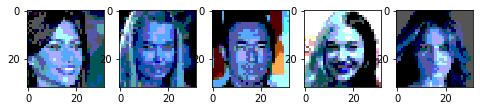

In [6]:
show(DATA['train'][:5])

In [0]:
class Block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Block, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(
                in_dim, out_dim, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.Conv2d(
                out_dim, in_dim, kernel_size=3,
                stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(in_dim)
        )
        self.after = nn.ReLU()

    def forward(self, x):
        out = self.layers(x)
        out += x
        out = self.after(out)
        return out


class Resnet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Resnet, self).__init__()

        layers = [nn.Conv2d(
            in_dim, out_dim, kernel_size=3,
            stride=1, padding=1, bias=False
        )]
        layers += [Block(out_dim, out_dim) for _ in range(4)]
        out_planes = 2 * in_dim
        layers += [nn.Conv2d(
            out_dim, out_planes, kernel_size=3,
            stride=1, padding=1, bias=False
        )]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

In [18]:
Resnet(3, 2)(torch.randn((64, 3, 32, 32))).shape

torch.Size([64, 6, 32, 32])

In [0]:
class AffineCoupling(nn.Module):
    def __init__(self, mask, in_dim, out_dim):
        super(AffineCoupling, self).__init__()
        self.mask = mask.clone()
        self.resnet = Resnet(in_dim, out_dim)

    def forward(self, x):
        z = self.mask * x
        log_s, t = self.resnet(z).split(z.shape[1], dim=1)
        log_s = torch.tanh(log_s)
        z = z + (1 - self.mask) * (torch.exp(log_s) * x + t)
        logdet = (log_s * (1.0 - self.mask)).flatten(1).sum(dim=1, keepdim=True)
        return z, logdet

    def reverse(self, x):
        z = self.mask * x
        log_s, t = self.resnet(z).split(z.shape[1], dim=1)
        log_s = torch.tanh(log_s)
        z = z + (1 - self.mask) * (x - t) / torch.exp(log_s)
        return z

class NormalizationLayer(nn.Module):
    def __init__(self, c, h, w):
        super(NormalizationLayer, self).__init__()

        self.w = nn.Parameter(torch.ones([1, c, h, w]))
        self.b = nn.Parameter(torch.zeros([1, c, h, w]))

    def forward(self, x):
        x = x * self.w + self.b
        logdet = torch.log(self.w.abs() + 1e-8).flatten(1).sum(dim=1, keepdim=True)
        return x, logdet

    def reverse(self, x):
        x = (x - self.b) / self.w
        return x

In [0]:

def squeeze(x):
    n, c, h, w = x.shape
    return torch.nn.functional.unfold(x, (2, 2), stride=2).reshape(n, 4 * c, h // 2, w // 2)


def unsqueeze(x):
    n, c, h, w = x.shape
    return torch.nn.functional.fold(x.reshape(n, c, -1), (h * 2, w * 2), (2, 2), stride=2)


def checkerboard_mask(c, h, w):
    a = np.ones([1, c, h, w], dtype=np.bool)
    b = np.ones([1, c, h, w], dtype=np.bool)
    a[:, :, np.arange(1, h, 2), :] = False
    b[:, :, :, np.arange(0, w, 2)] = False
    return torch.tensor(a ^ b, dtype=torch.float32, device=DEVICE)


def channel_split_mask(c, h, w):
    mask = torch.zeros([1, c, h, w], dtype=torch.float32, device=DEVICE)
    idx = t = np.arange(0, c // 4) * 4
    idx = np.stack((idx, idx + 1), axis=1).reshape(-1)
    mask[:, idx, :, :] = 1.0
    return mask


def dequantize(x, alpha=0.05):
    z = alpha + (1.0 - alpha) * x / 4.0
    diag = (torch.ones_like(x) * (1.0 - alpha) / 4.0).flatten(start_dim=1)
    logdet = torch.log(diag.abs()).sum(dim=1, keepdim=True)
    return z, logdet


def reverse_dequantize(x, alpha=0.05):
    return 4.0 * (x - alpha) / (1.0 - alpha)


def get_logit(x):
    z = torch.log(x) - torch.log(1.0 - x)
    diag = (1.0 / x + 1.0 / (1.0 - x)).abs().flatten(start_dim=1)
    logdet = torch.log(diag + 1e-8).sum(dim=1, keepdim=True)
    return z, logdet


def reverse_logit(x):
    z = torch.exp(x)
    return z / (z + 1.0)


def preprocess(x, alpha=0.05):
    deq, logdet1 = dequantize(x, alpha)
    z, logdet2 = get_logit(deq)
    logdet = logdet1 + logdet2
    return z, logdet


def reverse_preprocess(x, alpha=0.05):
    z = reverse_logit(x)
    z = reverse_dequantize(z, alpha)
    return z

In [0]:
class CelebA(nn.Module):
    def __init__(self, in_dim, h, w):
        super(CelebA, self).__init__()
        self.prior = torch.distributions.normal.Normal(0, 1)

        self.layers1 = nn.ModuleList()
        mask = checkerboard_mask(in_dim, h, w)
        for _ in range(4):
            self.layers1.append(AffineCoupling(mask, in_dim, 32))
            self.layers1.append(NormalizationLayer(in_dim, h, w))
            mask = 1.0 - mask
        in_dim, h, w = in_dim * 4, h // 2, w // 2
        self.layers2 = nn.ModuleList()
        mask = channel_split_mask(in_dim, h, w)
        for _ in range(3):
            self.layers2.append(AffineCoupling(mask, in_dim, 32))
            self.layers2.append(NormalizationLayer(in_dim, h, w))
            mask = 1.0 - mask
        self.layers3 = nn.ModuleList()
        mask = checkerboard_mask(in_dim, h, w)
        for _ in range(3):
            self.layers3.append(AffineCoupling(mask, in_dim, 32))
            self.layers3.append(NormalizationLayer(in_dim, h, w))
            mask = 1.0 - mask
        in_dim, h, w = in_dim * 4, h // 2, w // 2
        self.layers4 = nn.ModuleList()
        mask = channel_split_mask(in_dim, h, w)
        for _ in range(3):
            self.layers4.append(AffineCoupling(mask, in_dim, 32))
            self.layers4.append(NormalizationLayer(in_dim, h, w))
            mask = 1.0 - mask
        self.layers5 = nn.ModuleList()
        mask = checkerboard_mask(in_dim, h, w)
        for i in range(3):
            self.layers5.append(AffineCoupling(mask, in_dim, 32))
            self.layers5.append(NormalizationLayer(in_dim, h, w))
            mask = 1.0 - mask

    def forward(self, x):
        x, logdet = preprocess(x)
        for layer in self.layers1:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        x = squeeze(x)
        for layer in self.layers2:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        for layer in self.layers3:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        x = squeeze(x)
        for layer in self.layers4:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        for layer in self.layers5:
            x, x_logdet = layer(x)
            logdet = logdet + x_logdet
        return unsqueeze(unsqueeze(x)), logdet

    def log_prob(self, x):
        z, logdet = self.forward(x)
        log_pz = self.prior.log_prob(z).flatten(start_dim=1).sum(dim=1, keepdim=True)
        return (-log_pz - logdet).mean()

    def reverse(self, x):
        x = squeeze(squeeze(x))
        for layer in reversed(self.layers5):
            x = layer.reverse(x)
        for layer in reversed(self.layers4):
            x = layer.reverse(x)
        x = unsqueeze(x)
        for layer in reversed(self.layers3):
            x = layer.reverse(x)
        for layer in reversed(self.layers2):
            x = layer.reverse(x)
        x = unsqueeze(x)
        for layer in reversed(self.layers1):
            x = layer.reverse(x)
        return reverse_preprocess(x)
    
    def sample(self, n):
        return self.prior.sample([n, 3, 32, 32]).to(DEVICE)

In [92]:
CelebA(3, 32, 32).to(DEVICE).log_prob(torch.randn((5, 3, 32, 32)).to(DEVICE))

tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
def count_parameters():
    model = CelebA(3, 32, 32)
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [94]:
count_parameters()

1607552

In [0]:
def train(model, train_batch_size, test_batch_size, epochs_cnt, train_data=DATA['train'], test_data=DATA['test'], lr=5e-4):
    dim_factor = torch.FloatTensor([3 * 32 * 32]).to(DEVICE)
    log_factor = torch.log(torch.Tensor([2])).to(DEVICE)
        
    def loss_func(log_prob):
        return -torch.mean(log_prob) / dim_factor / log_factor
    
    train_iter = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    val_iter = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)
    optimizer = torch.optim.Adam(MODEL.parameters(),lr=lr, weight_decay=0)

    losses, val_losses = [], []
    start = time.time()
    for epoch in range(epochs_cnt):
        loss = 0
        tmp_losses = []
        
        model.train()
        total_train_loss = 0
        for batch in train_iter:
            batch = batch.to(DEVICE)
            loss = model.log_prob(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            tmp_losses.append(loss.data.cpu().numpy())
        losses.append(np.mean(tmp_losses))
        
        model.eval()
        with torch.no_grad():
            tmp_val_losses = []
            for item in val_iter:
                batch = batch.to(DEVICE)
                val_loss = model.log_prob(batch)
                tmp_val_losses.append(val_loss.data.cpu().numpy())
            val_losses.append(np.mean(tmp_val_losses))
        if (epoch + 1) % 10 == 0:
            print('Epoch {}: loss {} val_loss {} '.format(epoch, np.mean(tmp_losses), np.mean(tmp_val_losses)))
            torch.save(model.state_dict(), './gdrive/My Drive/CelebA.pt')
            print('Model saved!')
            with open('./gdrive/My Drive/CelebA_train_loss.pkl', 'wb') as f:
                pickle.dump(losses, f)
            with open('./gdrive/My Drive/CelebA_val_loss.pkl', 'wb') as f:
                pickle.dump(val_losses, f)
            end = time.time()
            elapsed = end - start
            start = end
            print(f'Elapsed time: {elapsed}')
    return losses, val_losses

In [0]:
def plot_losses(losses, val_losses):
    plt.plot(losses, label = "train_loss")
    plt.plot(val_losses, label = "val_loss")
    plt.legend()
    plt.show()

In [0]:
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
EPOCHS_CNT = 300

In [0]:
MODEL = CelebA(3, 32, 32).to(DEVICE)

In [134]:
TRAIN_LOSSES, VAL_LOSSES = train(MODEL, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, EPOCHS_CNT, train_data=DATA['train'], test_data=DATA['test'])
_ = MODEL.eval()

Epoch 9: loss 4512.27685546875 val_loss 206026576.0 
Model saved!
Elapsed time: 2.751368522644043
Epoch 19: loss 2378.424560546875 val_loss 10932899.0 
Model saved!
Elapsed time: 2.7248611450195312
Epoch 29: loss 1542.8341064453125 val_loss 33415.57421875 
Model saved!
Elapsed time: 2.7701399326324463
Epoch 39: loss 1072.416259765625 val_loss 1908.2578125 
Model saved!
Elapsed time: 3.0004467964172363
Epoch 49: loss 780.9027709960938 val_loss 1061.8514404296875 
Model saved!
Elapsed time: 2.700639486312866
Epoch 59: loss 476.21435546875 val_loss 708.995849609375 
Model saved!
Elapsed time: 2.7728960514068604
Epoch 69: loss 325.923583984375 val_loss 413.8211364746094 
Model saved!
Elapsed time: 2.7294094562530518
Epoch 79: loss 197.70787048339844 val_loss 194.80947875976562 
Model saved!
Elapsed time: 2.734764814376831
Epoch 89: loss -36.7552375793457 val_loss 68.32958984375 
Model saved!
Elapsed time: 2.7282607555389404
Epoch 99: loss -149.22203063964844 val_loss -54.33892822265625 
Mo

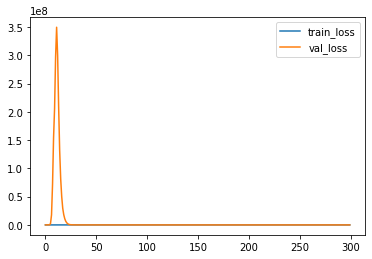

In [135]:
plot_losses(TRAIN_LOSSES, VAL_LOSSES)

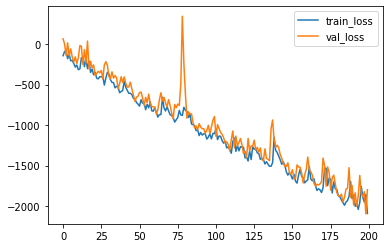

In [136]:
plot_losses(TRAIN_LOSSES[100:], VAL_LOSSES[100:])

In [0]:
def interpolate(model):
    left_faces = DATA['train'][[10, 100, 1000]].to(DEVICE)
    right_faces = DATA['train'][[11, 101, 1001]].to(DEVICE)

    imgs = [[], [], []]
    with torch.no_grad():
        for i in range(3):
            left, b = left_faces[i].unsqueeze(0), right_faces[i].unsqueeze(0)
            z_left, _ = model(left)
            z_right, _ = model(b)
            ts = [j / 7 for j in range(8)]
            for t in ts:
                x = model.reverse((1 - t) * z_left + t * z_right)
                x = x.permute(0, 2, 3, 1).cpu().numpy()[0]
                imgs[i].append(np.clip(x / 3, 0, 1))

    f, ax = plt.subplots(3, 8)
    plt.title('INTERPOLATION')
    f.set_figheight(4)
    f.set_figwidth(15)
    for i in range(3):
        for j in range(8):
            ax[i, j].imshow(imgs[i][j])
    plt.show()

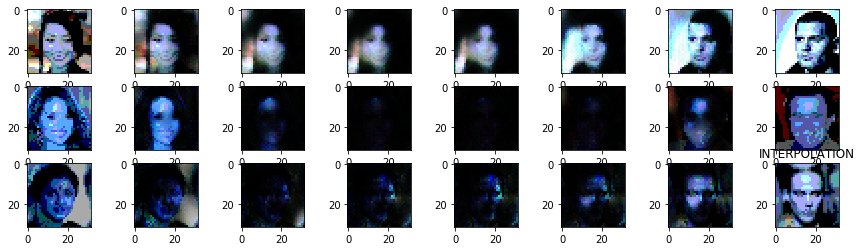

In [138]:
interpolate(MODEL)

In [0]:
def draw_images(images):
    f, ax = plt.subplots(images.shape[0], images.shape[1])
    f.set_figheight(25)
    f.set_figwidth(25)
    for i in range(images.shape[0]):
        for j in range(images.shape[1]):
            ax[i, j].imshow(images[i][j])
    plt.show()


def draw_samples(model):
    z = model.sample(100)
    images = model.reverse(z).permute(0, 2, 3, 1).cpu().detach().numpy()
    images = np.clip(images / 3, 0, 1).reshape(10, 10, images.shape[1], images.shape[2], images.shape[3])
    draw_images(images)

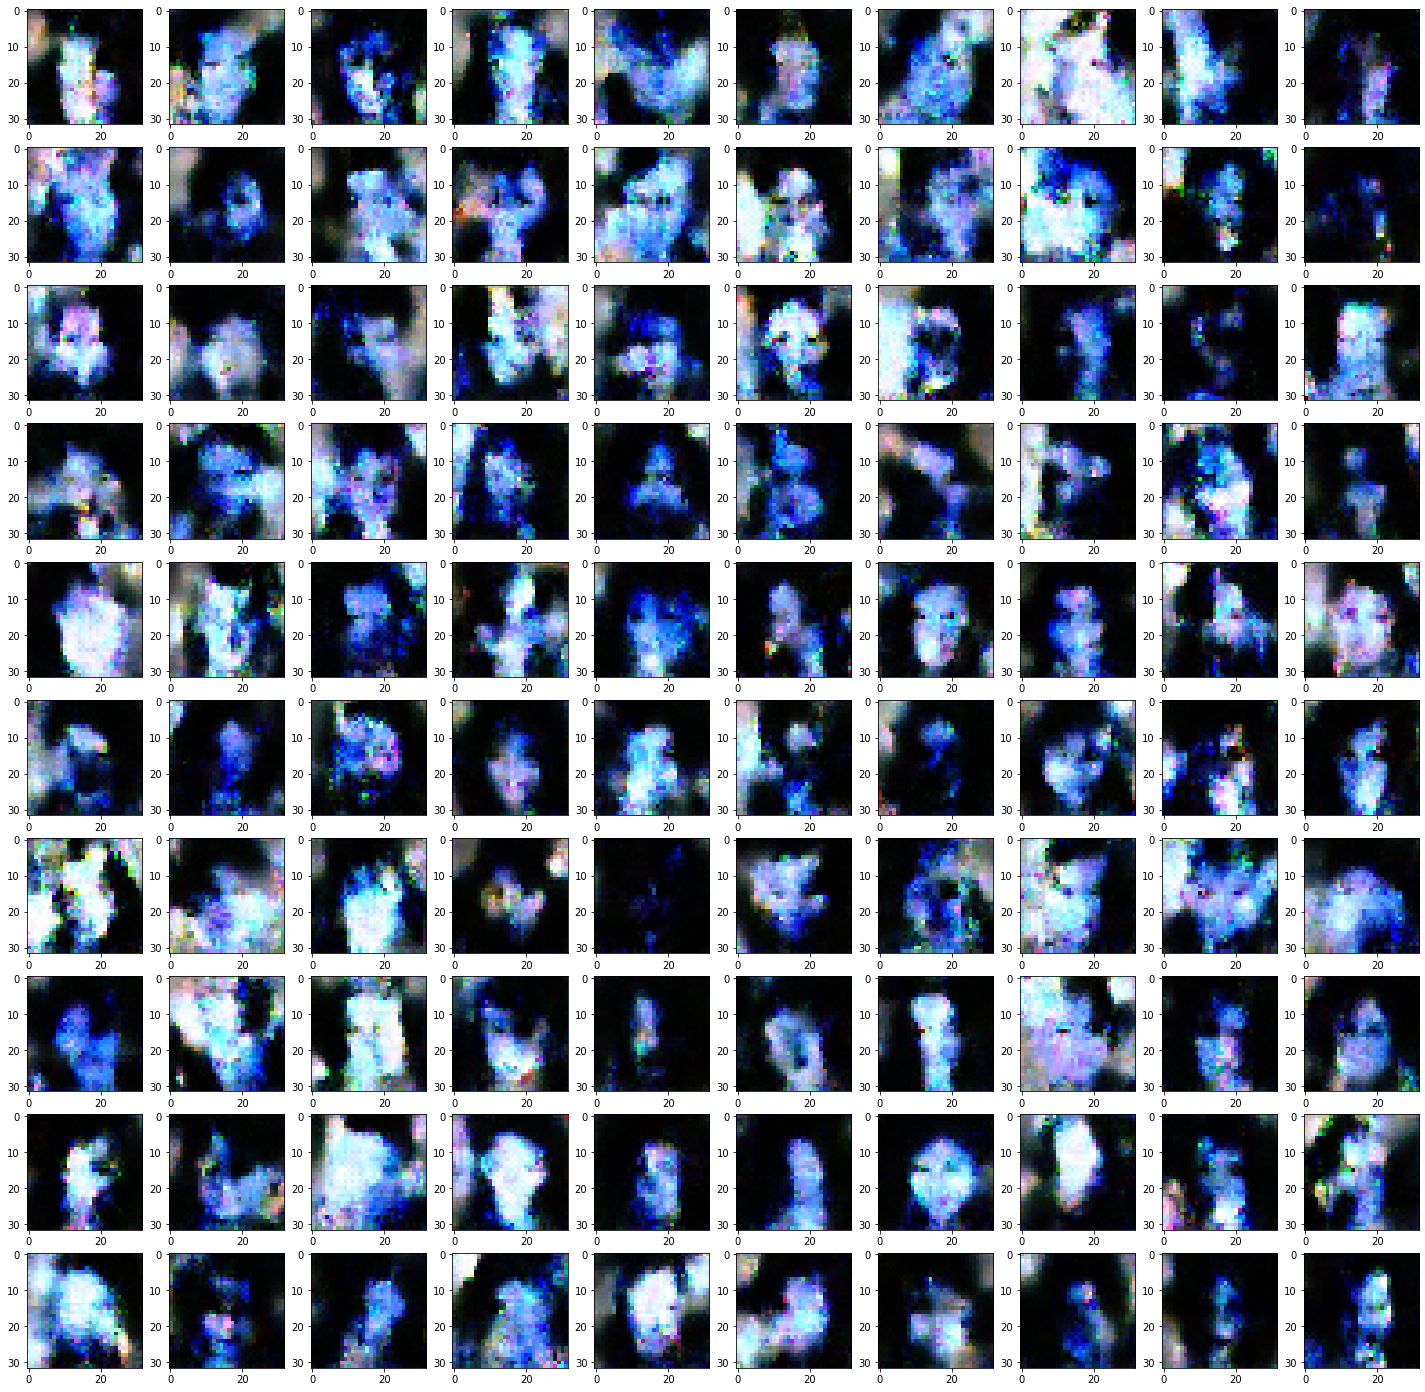

In [140]:
draw_samples(MODEL)